In [1]:
import chess.engine
import chess 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import chess.pgn 
from stockfish import Stockfish
import pandas as pd
import time
import numpy as np
import json

In [ ]:
def stockfish_mm(moves, stockfish):
    if len(moves) <= 7:
        return None
    mm_w = []
    mm_b = []
    board = chess.Board()

    # exclude the first 6 moves in our analysis
    for j in range(6):
        board.push_san(moves[j])
        
    for i in range(6, len(moves)):
    
        if i%2 == 0:
            stockfish.set_fen_position(board.fen())
            best_move = stockfish.get_best_move()
            mm_w.append(best_move == moves[i])
        else:
        #if i%2 == 1:
            stockfish.set_fen_position(board.fen())
            best_move = stockfish.get_best_move()
            mm_b.append(best_move == moves[i])

        board.push_san(moves[i])
    

    # Calculate the proportion of True values
    proportion_true_w = sum(mm_w) / len(mm_w)
    proportion_true_b = sum(mm_b) / len(mm_b)

    return (proportion_true_w, proportion_true_b)

## Improving code

Here we aim to create a new dataframe with the columns:

- elo rating
- MM for Maia 1100
- MM for Maia 1200
- MM for Maia 1300
- MM for Maia 1400
- MM for Maia 1500
- MM for Maia 1600
- MM for Maia 1700
- MM for Maia 1800
- MM for Maia 1900
- MM for Stockfish depth 12

In [35]:
aggregated = {}

# Define rating bins
bins = np.arange(1050, 2250, 100)
labels = [int(f"{(2*i+100)/2:.0f}") for i in bins[:-1]]

# Here we read in the move match ratings and aggregate them based on their closest 100th
for i in range (1, 10):
    path = f"../data/curated/maia-1{i}00.ndjson"
    df = pd.read_json(path, lines=True)
    
    # Adding a rating group variable to help determin the bins each instance is allocated to
    df['rating_group'] = pd.cut(df['elo'], bins=bins, labels=labels, right=False)

    # Aggregating the move matches by their respective bins
    aggregated[f"maia-1{i}00"] = df.groupby('rating_group', observed=False)['mm'].mean().reset_index()

df = pd.read_json("../data/curated/stockfish.ndjson", lines=True)
df['rating_group'] = pd.cut(df['elo'], bins=bins, labels=labels, right=False)
aggregated[f"stockfish"] = df.groupby('rating_group', observed=False)['mm'].mean().reset_index()
df.head()


,elo,mm,rating_group
0,1309,0.388889,1300
1,1309,0.388889,1300
2,1568,0.333333,1600
3,1568,0.333333,1600
4,1903,0.333333,1900


['#440154', '#472d7b', '#3b528b', '#2c728e', '#21918c', '#28ae80', '#5ec962', '#addc30', '#fde725']


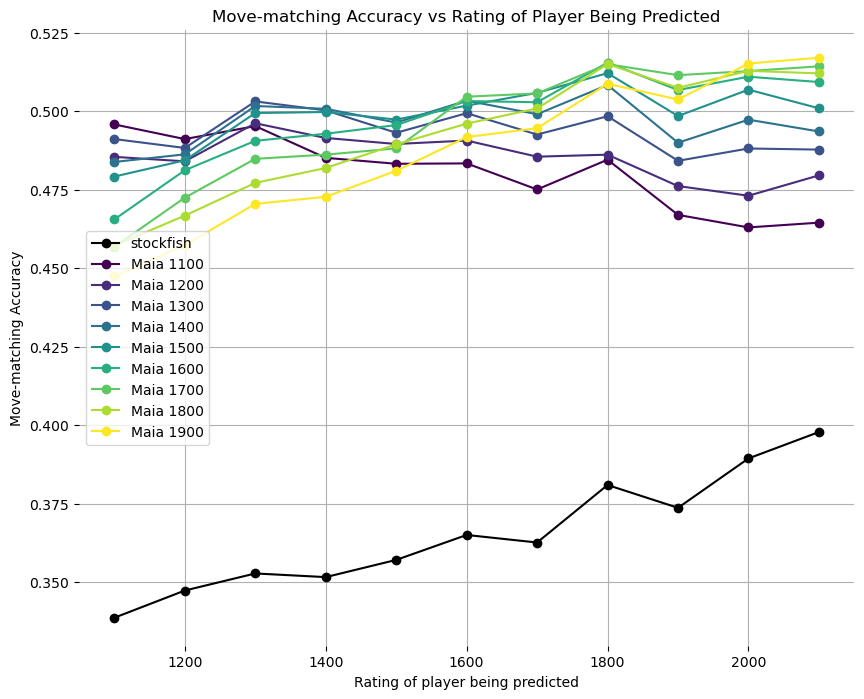

In [44]:
# Generate 9 evenly spaced values between 0 and 1
levels = np.linspace(0, 1, 9)
viridis = plt.get_cmap('viridis')
colors = [mcolors.to_hex(viridis(level)) for level in levels]
print(colors)

# plotting all the aggregated results
plt.figure(figsize=(10, 8))

plt.plot(aggregated["stockfish"]["rating_group"], aggregated["stockfish"]["mm"], label='stockfish', marker='o', color = 'black' )# color='#FF6347'

for i in range(1, 10):
    group = f"maia-1{i}00"
    plt.plot(aggregated[group]["rating_group"], aggregated[group]["mm"], label=f'Maia 1{i}00', marker='o', color = colors[i-1] )# color='#FF6347'

plt.xlabel('Rating of player being predicted')
plt.ylabel('Move-matching Accuracy')
plt.title('Move-matching Accuracy vs Rating of Player Being Predicted')
plt.legend(loc='center left')
plt.grid(True)

# Customize the plot background color
#plt.gca().set_facecolor('#FFF8DC')  # Similar to the background in the provided plot
# Remove the plot outline (spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('../plots/mm_maia.png', dpi=400)
plt.show()